In [1]:
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout, Bidirectional
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.layers.merge import Concatenate
import matplotlib.gridspec as gridspec

import random
import scikitplot as skplot
import matplotlib.pyplot as plt

Using TensorFlow backend.
C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as

In [2]:
#https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/

#url = "nflx.csv"
url="dpz.csv"

df = pd.read_csv(url)

df.columns = [x.lower() for x in df.columns]
#print(df.head())
df=df.sort_values(by="date")
df=df.reset_index()

df=df.drop(["high","low","adj close"],axis=1)
print(df.columns)

df['open_pct_change']=df['open'].pct_change()

print(df["open_pct_change"])

df["open_pct_positive_count"]=0

#######caculate the occurrences of positive open
for index in range(len(df)):
    #print(df.iloc[index])
    count=0
    for index2 in (range(index,0,-1)):
        #print(df.iloc[index2]["open_pct_change"])
        if df.iloc[index2]["open_pct_change"]>0:
            count=count+1
            #print("found",count)
        else:
            break
    #print("count",count)
    df.iloc[index, df.columns.get_loc('open_pct_positive_count')]=count
    #print("new",df.iloc[index]["pct_pos_count"])
    
print(df[df["open_pct_positive_count"]>0])    



Index(['index', 'date', 'open', 'close', 'volume'], dtype='object')
0           NaN
1     -0.008078
2      0.024859
3      0.035471
4     -0.018028
         ...   
248   -0.002211
249   -0.002464
250   -0.015372
251   -0.002281
252   -0.009323
Name: open_pct_change, Length: 253, dtype: float64
     index        date        open       close   volume  open_pct_change  \
2        2  2019-10-25  263.029999  271.750000  1436600         0.024859   
3        3  2019-10-28  272.359985  269.459991   628400         0.035471   
6        6  2019-10-31  271.670013  271.619995   732500         0.031710   
7        7  2019-11-01  272.929993  269.260010   534800         0.004638   
10      10  2019-11-06  276.829987  277.820007   544500         0.036894   
..     ...         ...         ...         ...      ...              ...   
237    237  2020-10-01  427.109985  426.989990   528300         0.004965   
239    239  2020-10-05  433.660004  424.940002  1024200         0.019153   
241    241  2020-10-0

In [3]:
####### if the occurrences were greater than 2, did the pct change stay positive

df["target"]=0
for index in range(len(df)):
    pct_chg=df.iloc[index]["open_pct_change"]
    if index!=0:
        prior_pct_chg_count=df.iloc[index-1]["open_pct_positive_count"]
        if (prior_pct_chg_count>=2) & (pct_chg>0):
             df.iloc[index, df.columns.get_loc('target')]=1
        
buy_list=df[df["target"]==1]
for index,item in buy_list.iterrows():
    print(item["date"],item["open"],item["open_pct_positive_count"])

2019-11-08 282.679993 3
2019-11-18 281.22000099999997 3
2019-11-19 284.619995 4
2019-11-20 286.48999 5
2019-11-21 287.26001 6
2020-02-07 284.459991 3
2020-02-14 285.97000099999997 3
2020-02-18 293.23999 4
2020-02-19 297.98999 5
2020-02-20 362.02999900000003 6
2020-02-21 366.01001 7
2020-04-06 340.0 3
2020-04-07 347.27999900000003 4
2020-04-20 364.660004 3
2020-04-21 370.480011 4
2020-04-22 373.320007 5
2020-04-23 379.910004 6
2020-05-07 371.0 3
2020-06-03 387.0 3
2020-06-04 390.399994 4
2020-06-11 387.0 3
2020-07-02 377.540009 3
2020-07-06 378.0 4
2020-07-07 384.73999 5
2020-07-13 402.0 3
2020-07-17 410.0 3
2020-08-07 392.579987 3
2020-08-14 399.980011 3
2020-08-17 401.0 4
2020-08-18 410.0 5
2020-08-19 413.450012 6
2020-09-11 401.390015 3
2020-09-22 404.959991 3
2020-09-23 414.570007 4
2020-09-29 422.200012 3
2020-09-30 425.0 4
2020-10-01 427.10998499999994 5


   open_pct_positive_count  Incidence  Size
0                        0          0   114
1                        1          0    67
2                        2          0    35
3                        3          1    17
4                        4          1     9
5                        5          1     6
6                        6          1     4
7                        7          1     1
17
incidence show the average target value for each group


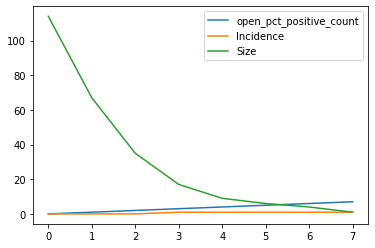

     index        date        open       close   volume  open_pct_change  \
0        0  2019-10-23  258.739990  256.000000   622200              NaN   
1        1  2019-10-24  256.649994  263.600006   852500        -0.008078   
4        4  2019-10-29  267.450012  263.179993  1159700        -0.018028   
5        5  2019-10-30  263.320007  270.899994   684900        -0.015442   
8        8  2019-11-04  268.059998  269.290009   824400        -0.017843   
..     ...         ...         ...         ...      ...              ...   
248    248  2020-10-16  401.720001  399.450012   530600        -0.002211   
249    249  2020-10-19  400.730011  394.890015   380300        -0.002464   
250    250  2020-10-20  394.570007  394.410004   487100        -0.015372   
251    251  2020-10-21  393.670013  389.950012   523400        -0.002281   
252    252  2020-10-22  390.000000  391.739990   442200        -0.009323   

     open_pct_positive_count  target  
0                          0       0  
1        

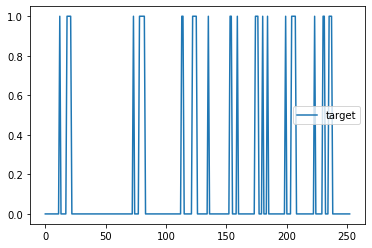

In [4]:
def create_pig_table(basetable, target, variable):
  
    # Create groups for each variable
    groups = basetable[[target,variable]].groupby(variable)
    
    pig_table=groups[target].agg([np.mean, np.size]).reset_index()
    pig_table=pig_table.rename(columns={'mean':'Incidence','size':'Size'})
    #pig_table = groups[target].agg({'Incidence' : np.mean, 'Size' : np.size}).reset_index()

    # Return the predictor insight graph table
    return pig_table

# Calculate the predictor insight graph table for the variable gender
pig_table = create_pig_table(df, "target", "open_pct_positive_count")
print(pig_table)

print(len(df[df['open_pct_positive_count']==3]))

print("incidence show the average target value for each group")

pig_table.plot()
plt.show()
#(df["open_pct_pos_count"]==4)&
print(df[(df["target"]==0)&(df["open_pct_positive_count"]==0)])

df.plot(y="target")  #buy
plt.show()


In [188]:
#X = df.drop(["date","target"], axis = 1)
#y = df["target"]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, stratify = y, random_state = 42)
timeSteps=30
#X_train = np.resize(X_train,(X_train.shape[0],timeSteps,X_train.shape[1]))


train_split= 0.9
split_idx = int(len(X) * 0.9)
training_set = df[:split_idx].values
test_set = df[split_idx:].values


n_future=5
n_past=30


X_train , y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0] , X_train.shape[1], 1))

pct_chg_column=4
X_test = test_set[: n_past, pct_chg_column]
#print(X_test)

target_column=6
#n_past : n_past + n_future
print(n_past + n_future)
y_test = test_set[n_past + n_future, target_column]
print(y_test)

#convert to an array
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (1, X_test.shape[0], 1))



samples=X_train.shape[0]

features=len(X.columns)

35


IndexError: index 35 is out of bounds for axis 0 with size 26

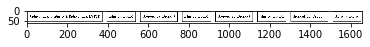

In [105]:
#1. The LSTM input layer must be 3D.
#2. The meaning of the 3 input dimensions are: samples, time steps, and features.
#3. The LSTM input layer is defined by the input_shape argument on the first hidden layer.
#4. The input_shape argument takes a tuple of two values that define the number of time steps and features.
#5. The number of samples is assumed to be 1 or more.

#Samples. One sequence is one sample. A batch is comprised of one or more samples.
#Time Steps. One time step is one point of observation in the sample.
#Features. One feature is one observation at a time step.

#input layer expects a 3D array of data when fitting the model and when making predictions, 
#even if specific dimensions of the array contain a single value, e.g. one sample or one feature.

#The input shape is supposed in the format (no_of_samples,no_of_timesteps,features)

#The input to every LSTM layer must be three-dimensional.
# expected input data shape: (batch_size, timesteps, data_dim)

n_future = 1
model = Sequential()

model.add(Bidirectional(LSTM(units=30, return_sequences=True, 
                             input_shape=(timeSteps, features))))

#old -- model.add(LSTM(30, activation='sigmoid', return_sequences=True,
#              input_shape=(timeSteps, features)))  # returns a sequence of vectors of dimension 

#model.add(LSTM(features, activation='sigmoid', return_sequences=True))  # returns a sequence of vectors of dimension 
#model.add(LSTM(30, activation='sigmoid'))  # return a single vector of dimension 
#model.add(Dense(1, activation='sigmoid'))
#model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])

model.add(LSTM(units= features, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units= features, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units= features))
model.add(Dropout(0.2))
model.add(Dense(units = n_future, activation="relu"))

model.compile(optimizer="adam", loss="mean_squared_error", metrics=["acc"])



plot_model(model, to_file='model.png')
img=plt.imread('model.png')
plt.imshow(img)
plt.show()



In [106]:
model.fit(X_train, np.array(y_train),epochs=500, batch_size=32  )

Epoch 1/500
170/170 [==============================] - 2s 9ms/step - loss: nan - acc: 0.1176
Epoch 2/500
170/170 [==============================] - 0s 701us/step - loss: nan - acc: 0.0000e+00
Epoch 3/500
170/170 [==============================] - 0s 696us/step - loss: nan - acc: 0.0000e+00
Epoch 4/500
170/170 [==============================] - 0s 628us/step - loss: nan - acc: 0.0000e+00
Epoch 5/500
170/170 [==============================] - 0s 764us/step - loss: nan - acc: 0.0000e+00
Epoch 6/500
170/170 [==============================] - 0s 672us/step - loss: nan - acc: 0.0000e+00
Epoch 7/500
170/170 [==============================] - 0s 607us/step - loss: nan - acc: 0.0000e+00
Epoch 8/500
170/170 [==============================] - 0s 698us/step - loss: nan - acc: 0.0000e+00
Epoch 9/500
170/170 [==============================] - 0s 815us/step - loss: nan - acc: 0.0000e+00
Epoch 10/500
170/170 [==============================] - 0s 786us/step - loss: nan - acc: 0.0000e+00
Epoch 11/500
17

170/170 [==============================] - 0s 716us/step - loss: nan - acc: 0.0000e+00
Epoch 164/500
170/170 [==============================] - 0s 969us/step - loss: nan - acc: 0.0000e+00
Epoch 165/500
170/170 [==============================] - 0s 829us/step - loss: nan - acc: 0.0000e+00
Epoch 166/500
170/170 [==============================] - 0s 866us/step - loss: nan - acc: 0.0000e+00
Epoch 167/500
170/170 [==============================] - 0s 719us/step - loss: nan - acc: 0.0000e+00
Epoch 168/500
170/170 [==============================] - 0s 719us/step - loss: nan - acc: 0.0000e+00
Epoch 169/500
170/170 [==============================] - 0s 629us/step - loss: nan - acc: 0.0000e+00
Epoch 170/500
170/170 [==============================] - 0s 701us/step - loss: nan - acc: 0.0000e+00
Epoch 171/500
170/170 [==============================] - 0s 719us/step - loss: nan - acc: 0.0000e+00
Epoch 172/500
170/170 [==============================] - 0s 698us/step - loss: nan - acc: 0.0000e+00
Epoc

170/170 [==============================] - 0s 654us/step - loss: nan - acc: 0.0000e+00
Epoch 324/500
170/170 [==============================] - 0s 696us/step - loss: nan - acc: 0.0000e+00
Epoch 325/500
170/170 [==============================] - 0s 625us/step - loss: nan - acc: 0.0000e+00
Epoch 326/500
170/170 [==============================] - 0s 716us/step - loss: nan - acc: 0.0000e+00
Epoch 327/500
170/170 [==============================] - 0s 604us/step - loss: nan - acc: 0.0000e+00
Epoch 328/500
170/170 [==============================] - 0s 724us/step - loss: nan - acc: 0.0000e+00
Epoch 329/500
170/170 [==============================] - 0s 742us/step - loss: nan - acc: 0.0000e+00
Epoch 330/500
170/170 [==============================] - 0s 675us/step - loss: nan - acc: 0.0000e+00
Epoch 331/500
170/170 [==============================] - 0s 791us/step - loss: nan - acc: 0.0000e+00
Epoch 332/500
170/170 [==============================] - 0s 648us/step - loss: nan - acc: 0.0000e+00
Epoc

170/170 [==============================] - 0s 827us/step - loss: nan - acc: 0.0000e+00
Epoch 486/500
170/170 [==============================] - 0s 735us/step - loss: nan - acc: 0.0000e+00
Epoch 487/500
170/170 [==============================] - 0s 735us/step - loss: nan - acc: 0.0000e+00
Epoch 488/500
170/170 [==============================] - 0s 735us/step - loss: nan - acc: 0.0000e+00
Epoch 489/500
170/170 [==============================] - 0s 735us/step - loss: nan - acc: 0.0000e+00
Epoch 490/500
170/170 [==============================] - 0s 735us/step - loss: nan - acc: 0.0000e+00
Epoch 491/500
170/170 [==============================] - 0s 735us/step - loss: nan - acc: 0.0000e+00
Epoch 492/500
170/170 [==============================] - 0s 643us/step - loss: nan - acc: 0.0000e+00
Epoch 493/500
170/170 [==============================] - 0s 735us/step - loss: nan - acc: 0.0000e+00
Epoch 494/500
170/170 [==============================] - 0s 863us/step - loss: nan - acc: 0.0000e+00
Epoc

In [108]:
prediction = model.predict(X_test)
print('Predicted {}'.format(prediction))
print('Real {}'.format(y_test))

ValueError: Error when checking input: expected sequential_12_input to have 3 dimensions, but got array with shape (84, 5)